# Spike Gadgets Ephys and Video Syncing

# TODO

- [] Refactor the trodes extraction functions

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_943495/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [11]:
protocol_name = "tethered_with_medpc"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = "./data"

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [14]:
raw_data_glob_pattern = "./data/subj_6_1"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [15]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [16]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [17]:
raw_data_file_path

'./data/subj_6_1'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [18]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/../../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/data/subj_6_1/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.kilosort/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projec

file prefix: group0.coordinates.dat
directory prefix: raw
file prefix: raw_group0.dat
directory prefix: raw
file prefix: timestamps.dat
directory prefix: raw
file prefix: group0.coordinates.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: kilosort
file prefix: group0.coordinates.dat
directory prefix: mountainsort
file prefix: spikes_nt28.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt30.dat
directory prefix: spikes
file prefix: spikes_nt26.dat
directory prefix: spikes
file prefix: spikes_nt25.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt31.dat
directory prefix: spikes
file prefix:

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/data/subj_6_1/logger_raw.dat
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/data/subj_6_1/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.trodesconf
  warnings.warn("Can not process {}".format

file prefix: analog_ECU_Ain3.dat
directory prefix: analog
file prefix: analog_Headstage_GyroZ.dat
directory prefix: analog
file prefix: analog_Controller_Ain1.dat
directory prefix: analog
file prefix: analog_Headstage_MagY.dat
directory prefix: analog
file prefix: analog_Headstage_AccelY.dat
directory prefix: analog
file prefix: analog_ECU_Ain2.dat
directory prefix: analog
file prefix: timestamps.dat
directory prefix: analog
file prefix: analog_ECU_Ain4.dat
directory prefix: analog
file prefix: analog_ECU_Ain7.dat
directory prefix: analog
file prefix: analog_Headstage_GyroY.dat
directory prefix: analog
file prefix: analog_ECU_Ain5.dat
directory prefix: analog
file prefix: timestamps.dat
directory prefix: stimulation
file prefix: spikeband_nt15ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt25ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt24ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt18ch1.dat
directory prefix: spikeband
file prefix: spikeband

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2022_12_11_om_and_comp_20221214_125409_subj_6_1_and_6_3/subject_6_1/data/subj_6_1/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))


- All the folders that were extracted from

In [19]:
file_to_data.keys()

dict_keys(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.raw', 'raw', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.kilosort', 'kilosort', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.mountainsort', 'mountainsort', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.spikes', 'spikes', '.', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.analog', 'analog', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.stimulation', 'stimulation', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.spikeband', 'spikeband', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.LFP', 'LFP', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.DIO', 'DIO'])

In [20]:
file_to_data["."]

{}

In [21]:
file_to_data["20221122_161341_omission_subject_6_1_top_4_base_2.spikeband"]

{}

- Looking over all the extracted data

In [22]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: 20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.raw
	File Name: group0.coordinates.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: Pad locations in microns

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Release_2

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: State change data for one digital channel. Display_order is 1-based

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Release_2.3.2-0-g15f12712

 	 	 Trodes Data Type: controller_firmware

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [23]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [24]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [25]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [26]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00129',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1671040463872',
 'timestamp_at_creation': '877254',
 'first_timestamp': '2951903',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([-134,  -16,  -28, -204, -275, -123,  135,   66,  125,  -35,  152,  -65, -132,   10,   48, -533,  397, -131, -142, -175,  -60,  -16,  -58,  135,  

- Array of Voltages for each channel

In [27]:
voltage_value_array = raw_recording_fields_text["data"]

In [28]:
voltage_value_array.shape

(15785984,)

In [29]:
voltage_value_array[:5]

array([([-134,  -16,  -28, -204, -275, -123,  135,   66,  125,  -35,  152,  -65, -132,   10,   48, -533,  397, -131, -142, -175,  -60,  -16,  -58,  135,  195,  -40, -121,  -72, -104,  -59, -171, -185],),
       ([ -33,   15,   53, -142, -238, -202,  169, -102,  214,  -48,   92,  -39, -174,   -7,   53, -489,  348, -115,  -96, -240,    5,   -5,   69,  172,   45,  -51,  -35,  -99,  -72,  -66,  -93,  -98],),
       ([  10,   -8,  151,  -24, -200,  -46,  190,  -73,  207,    1,   49,   10,  -75,   27,   79, -517,  333, -102,   -5, -219,    5,   22,  106,  241,  157,   71,  -45,  -29,  -69,  -86,  -54,   -7],),
       ([  42,  106,  136,   -1, -100,  -35,  169,  -24,  283,    2,  105,   73,  -27,   62,  144, -462,  333,   -7,   92, -111,   35,   90,   74,  323,  136,   56,   28,  -18,  -32,   82,   -2,   65],),
       ([ -66,  176,  142,   11, -110, -129,  241,  -55,  283,  -14,   88,    6, -170,   85,  143, -473,  338,  -47,   33,  -89,    9,   48,  105,  211,  152,  119,   22,   24,  -36,  

- Voltage Time Stamps

In [30]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [31]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [32]:
voltage_timestamp_array[:5]

array([(2951903,), (2951904,), (2951905,), (2951906,), (2951907,)],
      dtype=[('time', '<u4')])

In [33]:
voltage_timestamp_array[-5:]

array([(18746074,), (18746075,), (18746076,), (18746077,), (18746078,)],
      dtype=[('time', '<u4')])

In [34]:
voltage_timestamp_array.shape

(15794176,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [35]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [36]:
voltage_timestamp_array[:5]

array([2951903, 2951904, 2951905, 2951906, 2951907])

In [37]:
voltage_timestamp_array[-5:]

array([18746074, 18746075, 18746076, 18746077, 18746078])

In [38]:
voltage_timestamp_array.shape

(15794176,)

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [39]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [40]:
random_voltage_index

array([7069883])

In [41]:
voltage_value_array[random_voltage_index]

array([([ 424,  233,  348,  407,  593,  354,  492,  283,  379,  454,  467,  203,  470,  -86,  103,  729, -453,  392,  395,  387,  324,  273,  191,  155,  215,  342,  318,  378,  303,  539,  379,  433],)],
      dtype=[('voltage', '<i2', (32,))])

- Getting the associated timestamp of the ephys recording

In [42]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [43]:
random_voltage_time_stamp

array([10021786])

# Part 4: Converting from timestamps back to everything

In [44]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [45]:
random_voltage_time_stamp

array([10021786])

In [46]:
voltage_timestamp_array

array([ 2951903,  2951904,  2951905, ..., 18746076, 18746077, 18746078])

- Getting the index of the closest timestamp 

In [47]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [48]:
random_voltage_index

7069883

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [49]:
voltage_timestamp_array[random_voltage_index]

10021786

- Getting the voltage value based on the index

In [50]:
voltage_value_array[random_voltage_index]

([ 424,  233,  348,  407,  593,  354,  492,  283,  379,  454,  467,  203,  470,  -86,  103,  729, -453,  392,  395,  387,  324,  273,  191,  155,  215,  342,  318,  378,  303,  539,  379,  433],)

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

In [51]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [52]:
DIO_directory_name

'DIO'

In [53]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [54]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Din2.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Din11.dat', 'dio_ECU_Din21.dat', 'dio_ECU_Dout27.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Din9.dat', 'dio_ECU_Din13.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout18.dat', 'dio_ECU_Din29.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Dout25.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Dout1.dat', 'dio_ECU_Dout32.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Dout10.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Din18.dat', 'dio_ECU_Din31.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Din20.dat', 'dio_Controller_Din1.dat', 'dio_ECU_Dout7.dat', 'dio_ECU_Din30.dat', 'dio_Controller_Din2.dat', 'dio_ECU_Dout12.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Dout9.dat', 'dio_ECU_Dout4.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Din6.dat', 'dio_ECU

In [55]:
DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [56]:
DIN_file_name

'dio_ECU_Din1.dat'

In [57]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["data"]

In [58]:
DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

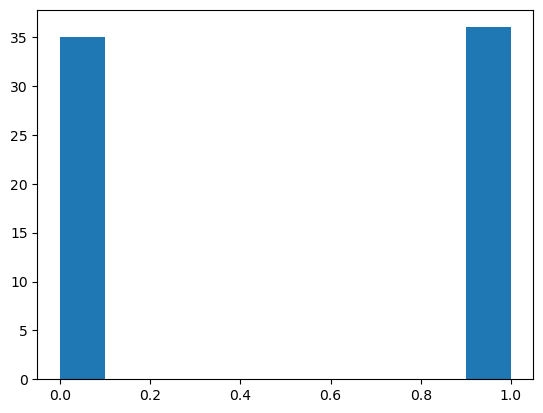

In [59]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

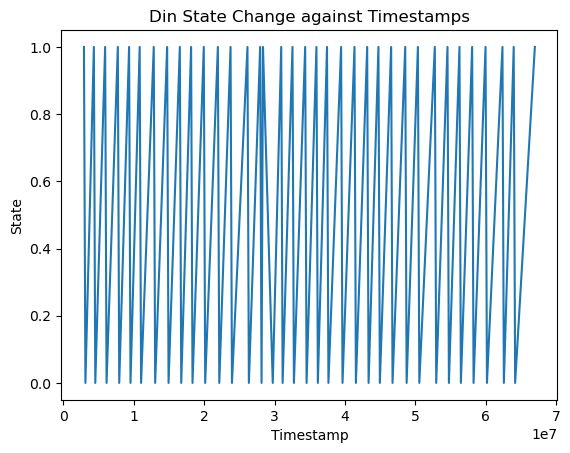

In [60]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# Reading in Phy

- The times that all the spikes happened

In [61]:
spike_times = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_times.npy")

In [62]:
spike_times[:10]

array([[ 11],
       [ 89],
       [143],
       [178],
       [215],
       [260],
       [309],
       [344],
       [413],
       [487]])

- Which unit the spike came from

In [63]:
spike_clusters = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_clusters.npy")

In [64]:
spike_clusters[:10]

array([39, 70, 60, 60,  1, 72, 19, 67, 72, 20], dtype=int32)

- The classification of each unit

In [65]:
cluster_group_df = pd.read_csv("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/cluster_group.tsv", sep="\t")

In [66]:
cluster_group_df

,cluster_id,group
0,0,noise
1,1,mua
2,2,noise
3,3,noise
4,4,mua
...,...,...
71,71,unsorted
72,72,unsorted
73,73,unsorted
74,74,unsorted


- Filtering for the good units

In [67]:
good_unit_unique_ids = cluster_group_df[cluster_group_df["group"] == "good"]["cluster_id"].values

In [68]:
good_unit_unique_ids

array([16, 20, 24, 52, 54, 64])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [69]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [70]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [71]:
good_unit_all_ids.shape

(77585,)

In [72]:
good_unit_all_ids[:10]

array([20, 24, 54, 54, 64, 20, 54, 52, 24, 54], dtype=int32)

- Getting the time that the good units fired

In [73]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [74]:
good_unit_times.shape

(77585,)

In [75]:
good_unit_times[:10]

array([ 487, 1190, 1701, 2087, 2467, 2537, 3212, 4330, 4951, 5936])

In [76]:
good_unit_times[-10:]

array([64092222, 64093462, 64096002, 64100027, 64100072, 64103863,
       64105033, 64106262, 64107502, 64113530])

In [77]:
spike_times

array([[      11],
       [      89],
       [     143],
       ...,
       [64113456],
       [64113530],
       [64113594]])

- spike_times are indexed based on the start of the recording, not the start of the streaming

In [78]:
spike_times[-1]/20000/3600

array([0.89046658])

## Syncing the unit times with the ECU times

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [79]:
DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

In [80]:
(4359951 - 3159550) / 20000

60.02005

In [81]:
(2951903 - 3159550) / 20000

-10.38235

- Getting only the times when the ECU signal was on

In [82]:
tone_din_time = [din_time for din_time, din_state in DIN_state_array if din_state == 1]

In [83]:
tone_din_time

[2951903,
 4359951,
 5959954,
 7759946,
 9359945,
 10859943,
 12859940,
 14759938,
 16559934,
 18159935,
 19959932,
 21959930,
 23759929,
 26159926,
 27959924,
 28359523,
 30950500,
 32550496,
 34350494,
 35950496,
 37450494,
 39450491,
 41350489,
 43150487,
 44750483,
 46550484,
 48550482,
 50350480,
 52750475,
 54550473,
 56250471,
 58050469,
 59950467,
 62350467,
 63950466,
 66950060]

- Because spike sorting is 0-indexed, we must make all the tone time also 0-indexed. We will do this by subtracting the first index from the ephys recording for all the tone times.

In [84]:
voltage_timestamp_array

array([ 2951903,  2951904,  2951905, ..., 18746076, 18746077, 18746078])

In [85]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time in tone_din_time]

In [86]:
all_tone_unit_time

[0,
 1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563,
 63998157]

- Checking to see what the time looks like for each tone. The first one is 0, so can be ignored. The last one can also be ignored because it's different by a smaller time than the time between tones compared to the previous one 

In [87]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 70.4024,
 150.40255,
 240.40215,
 320.4021,
 395.402,
 495.40185,
 590.40175,
 680.40155,
 760.4016,
 850.40145,
 950.40135,
 1040.4013,
 1160.40115,
 1250.40105,
 1270.381,
 1399.92985,
 1479.92965,
 1569.92955,
 1649.92965,
 1724.92955,
 1824.9294,
 1919.9293,
 2009.9292,
 2089.929,
 2179.92905,
 2279.92895,
 2369.92885,
 2489.9286,
 2579.9285,
 2664.9284,
 2754.9283,
 2849.9282,
 2969.9282,
 3049.92815,
 3199.90785]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [88]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [89]:
all_tone_unit_time

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

In [90]:
len(all_tone_unit_time)

34

## Seeing which tone belongs to reward training vs competition

- ITI times from MED-PC
    - 60 was not part of the list, but it is the inital delay of the tone from the start of the program

In [91]:
iti_times = [60, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]

- The number of reward trials and competition trials(along with what minute each happened)

```
Reward Trials
    0:       57.000
     1:       58.000
     2:        0.000
     3:        1.000
     4:        2.000
     5:        4.000
     6:        6.000
     7:        7.000
     8:        8.000
     9:       10.000
    10:       12.000
    11:       13.000
    12:       15.000
    13:       17.000
Competition Trials
     0:       19.000
     1:       20.000
     2:       22.000
     3:       23.000
     4:       24.000
     5:       26.000
     6:       28.000
     7:       29.000
     8:       31.000
     9:       32.000
    10:       34.000
    11:       35.000
    12:       37.000
    13:       39.000
    14:       40.000
    15:       42.000
    16:       43.000
    17:       45.000
    18:       47.000
```

In [92]:
previous_time = 0
for index, (time) in enumerate(all_tone_unit_time):
    print("Current Index: {} Current Time: {} Time Difference: {}".format(index, time, (time - previous_time) / 20000))
    previous_time = time

Current Index: 0 Current Time: 1408048 Time Difference: 70.4024
Current Index: 1 Current Time: 3008051 Time Difference: 80.00015
Current Index: 2 Current Time: 4808043 Time Difference: 89.9996
Current Index: 3 Current Time: 6408042 Time Difference: 79.99995
Current Index: 4 Current Time: 7908040 Time Difference: 74.9999
Current Index: 5 Current Time: 9908037 Time Difference: 99.99985
Current Index: 6 Current Time: 11808035 Time Difference: 94.9999
Current Index: 7 Current Time: 13608031 Time Difference: 89.9998
Current Index: 8 Current Time: 15208032 Time Difference: 80.00005
Current Index: 9 Current Time: 17008029 Time Difference: 89.99985
Current Index: 10 Current Time: 19008027 Time Difference: 99.9999
Current Index: 11 Current Time: 20808026 Time Difference: 89.99995
Current Index: 12 Current Time: 23208023 Time Difference: 119.99985
Current Index: 13 Current Time: 25008021 Time Difference: 89.9999
Current Index: 14 Current Time: 25407620 Time Difference: 19.97995
Current Index: 15

1. To get the tones that correspond to the first part(training), see where the first 70(60 + 10 to include tone for first tone) occurs
    - This is index 0
2. Then get all the tones until you reach the number of training tones(14)
3. Then starting off at the last index of the first part, see where the first 70(60 + 10 to include tone for first tone) occurs again
    - This is index 32
2. Then get all the tones until you reach the number of training tones(19)

In [93]:
training_trials = all_tone_unit_time[:14]
# Skipping one because that is when the system was turned on and off when switching programs
competition_trials = all_tone_unit_time[15:]

In [94]:
training_and_competition_trials = training_trials + competition_trials

In [95]:
len(training_trials)

14

In [96]:
len(competition_trials)

19

In [97]:
len(training_and_competition_trials)

33

In [98]:
training_trials

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021]

In [99]:
competition_trials

[27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [101]:
good_unit_bins = np.digitize(good_unit_times, training_and_competition_trials, right=True)

In [102]:
good_unit_bins.shape

(77585,)

In [103]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [104]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 5 second interval before or 10 second after any tone

In [105]:
from collections import defaultdict

In [106]:
within_interval_unit_times = defaultdict(list)
for index, time in enumerate(good_unit_times):
    try:
        current_bin = good_unit_bins[index]


        # checking number before
        first_tone_time = training_and_competition_trials[current_bin - 1]
        if time >= first_tone_time - 5 * 20000 and time <= first_tone_time + 10 * 20000:
            within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))

        # checking number after
        second_tone_time = training_and_competition_trials[current_bin]
        if time >= second_tone_time - 5 * 20000 and time <= second_tone_time + 10 * 20000:
            within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))
    except:
        pass

In [107]:
within_interval_unit_times[training_and_competition_trials[0]][:10]

[(1408048, 1915, 1308455, 20),
 (1408048, 1916, 1308605, 20),
 (1408048, 1917, 1309035, 20),
 (1408048, 1918, 1309076, 64),
 (1408048, 1919, 1309948, 54),
 (1408048, 1920, 1310824, 20),
 (1408048, 1921, 1311792, 20),
 (1408048, 1922, 1312528, 20),
 (1408048, 1923, 1312842, 64),
 (1408048, 1924, 1313003, 54)]

In [108]:
within_interval_unit_times[training_and_competition_trials[-1]][:10]

[(60998563, 74962, 60903015, 54),
 (60998563, 74963, 60904506, 54),
 (60998563, 74964, 60904971, 54),
 (60998563, 74965, 60905191, 16),
 (60998563, 74966, 60905737, 54),
 (60998563, 74967, 60906251, 54),
 (60998563, 74968, 60908575, 24),
 (60998563, 74969, 60909269, 20),
 (60998563, 74970, 60910250, 54),
 (60998563, 74971, 60910622, 54)]

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [109]:
tone_unit_time_to_interval = {}
for time in training_and_competition_trials:
    tone_unit_time_to_interval[time] = [time + num * 2000 for num in range(-50, 100)]

In [110]:
len(tone_unit_time_to_interval[training_and_competition_trials[0]])

150

- Seeing which bin the tone time fits into

In [111]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [112]:
all_bin_mapping

array([[ 1408048,     1915,  1308455,       20,        1],
       [ 1408048,     1916,  1308605,       20,        1],
       [ 1408048,     1917,  1309035,       20,        1],
       ...,
       [60998563,    75150, 61189530,       54,      146],
       [60998563,    75151, 61194804,       20,      149],
       [60998563,    75152, 61195544,       52,      149]])

## Calculating Firing Rate

In [113]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [114]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [115]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [116]:
tone_bin_to_tone

array([[ 1408049,  1408048],
       [ 1408049,  1408048],
       [ 1408049,  1408048],
       ...,
       [60998709, 60998563],
       [60998712, 60998563],
       [60998712, 60998563]])

In [117]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [118]:
tone_bin_to_tone

{1408049: 1408048,
 1408050: 1408048,
 1408051: 1408048,
 1408052: 1408048,
 1408053: 1408048,
 1408054: 1408048,
 1408055: 1408048,
 1408056: 1408048,
 1408057: 1408048,
 1408058: 1408048,
 1408059: 1408048,
 1408060: 1408048,
 1408061: 1408048,
 1408062: 1408048,
 1408063: 1408048,
 1408064: 1408048,
 1408065: 1408048,
 1408066: 1408048,
 1408067: 1408048,
 1408068: 1408048,
 1408069: 1408048,
 1408070: 1408048,
 1408071: 1408048,
 1408072: 1408048,
 1408073: 1408048,
 1408074: 1408048,
 1408075: 1408048,
 1408076: 1408048,
 1408077: 1408048,
 1408078: 1408048,
 1408079: 1408048,
 1408080: 1408048,
 1408081: 1408048,
 1408082: 1408048,
 1408083: 1408048,
 1408084: 1408048,
 1408085: 1408048,
 1408086: 1408048,
 1408087: 1408048,
 1408088: 1408048,
 1408089: 1408048,
 1408090: 1408048,
 1408091: 1408048,
 1408092: 1408048,
 1408093: 1408048,
 1408094: 1408048,
 1408095: 1408048,
 1408096: 1408048,
 1408097: 1408048,
 1408098: 1408048,
 1408099: 1408048,
 1408100: 1408048,
 1408101: 14

In [119]:
tone_bin_for_index

array([ 1408049,  1408049,  1408049, ..., 60998709, 60998712, 60998712])

- Getting the number of times each neuron fires

In [120]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [121]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [122]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [123]:
firing_rate_df.head()

,20,64,54,16,52,24
1408049,3.0,1.0,1.0,0.0,0.0,0.0
1408050,2.0,0.0,0.0,0.0,0.0,0.0
1408051,2.0,2.0,2.0,0.0,0.0,0.0
1408052,1.0,1.0,3.0,0.0,0.0,0.0
1408054,1.0,1.0,0.0,0.0,1.0,0.0


In [124]:
firing_rate_df.loc[:].values

array([[3., 1., 1., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0.],
       [2., 2., 2., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

- Classifying each time stamp

In [125]:
all_bin_mapping

array([[ 1408048,     1915,  1308455,       20,        1],
       [ 1408048,     1916,  1308605,       20,        1],
       [ 1408048,     1917,  1309035,       20,        1],
       ...,
       [60998563,    75150, 61189530,       54,      146],
       [60998563,    75151, 61194804,       20,      149],
       [60998563,    75152, 61195544,       52,      149]])

In [126]:
all_bin_mapping[:, 0]

array([ 1408048,  1408048,  1408048, ..., 60998563, 60998563, 60998563])

In [127]:
all_bin_mapping[:, 2]

array([ 1308455,  1308605,  1309035, ..., 61189530, 61194804, 61195544])

- Making a dictionary that maps all the firing times to the corresponding tone

In [128]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [129]:
fire_to_tone_time

{1308455: 1408048,
 1308605: 1408048,
 1309035: 1408048,
 1309076: 1408048,
 1309948: 1408048,
 1310824: 1408048,
 1311792: 1408048,
 1312528: 1408048,
 1312842: 1408048,
 1313003: 1408048,
 1313359: 1408048,
 1313864: 1408048,
 1313972: 1408048,
 1314518: 1408048,
 1315071: 1408048,
 1315342: 1408048,
 1315798: 1408048,
 1315873: 1408048,
 1317171: 1408048,
 1319293: 1408048,
 1319426: 1408048,
 1319739: 1408048,
 1320104: 1408048,
 1323009: 1408048,
 1323620: 1408048,
 1325653: 1408048,
 1325967: 1408048,
 1326267: 1408048,
 1326962: 1408048,
 1327531: 1408048,
 1327774: 1408048,
 1328103: 1408048,
 1331558: 1408048,
 1332596: 1408048,
 1332920: 1408048,
 1333298: 1408048,
 1333728: 1408048,
 1334090: 1408048,
 1336257: 1408048,
 1336328: 1408048,
 1336796: 1408048,
 1337376: 1408048,
 1338688: 1408048,
 1339254: 1408048,
 1339587: 1408048,
 1340532: 1408048,
 1341084: 1408048,
 1341934: 1408048,
 1342577: 1408048,
 1343212: 1408048,
 1343708: 1408048,
 1344039: 1408048,
 1344742: 14

In [130]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [131]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [132]:
firing_rate_df.head()

,index,20,64,54,16,52,24,tone_time
0,1408049,3.0,1.0,1.0,0.0,0.0,0.0,1408048
1,1408050,2.0,0.0,0.0,0.0,0.0,0.0,1408048
2,1408051,2.0,2.0,2.0,0.0,0.0,0.0,1408048
3,1408052,1.0,1.0,3.0,0.0,0.0,0.0,1408048
4,1408054,1.0,1.0,0.0,0.0,1.0,0.0,1408048


In [133]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

In [134]:
training_and_competition_trials

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

In [135]:
len(training_and_competition_trials)

33

## Categorizing Rewarded vs Omitted for Training

In [100]:
rewarded_trials = [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]

In [136]:
tone_to_reward = {}
for tone_time, reward_bool in zip(training_trials, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [137]:
tone_to_reward

{1408048: 1,
 3008051: 1,
 4808043: 1,
 6408042: 0,
 7908040: 1,
 9908037: 1,
 11808035: 1,
 13608031: 1,
 15208032: 0,
 17008029: 1,
 19008027: 1,
 20808026: 0,
 23208023: 1,
 25008021: 1}

In [138]:
len(tone_to_reward)

14

In [201]:
firing_rate_df["training_or_competition"] = firing_rate_df["tone_time"].apply(lambda x: "training" if x in tone_to_reward else "competition")

In [202]:
firing_rate_df["rewarded_bool"] = firing_rate_df["tone_time"].map(tone_to_reward)

In [203]:
firing_rate_df["rewarded_category"] = firing_rate_df["rewarded_bool"].map({0:"Omission", 1: "Rewarded"})

In [204]:
firing_rate_df

,index,20,64,54,16,52,24,tone_time,bin,rewarded_bool,rewarded_category,training_or_competition
0,1408049,3.0,1.0,1.0,0.0,0.0,0.0,1408048,1,1.0,Rewarded,training
1,1408050,2.0,0.0,0.0,0.0,0.0,0.0,1408048,2,1.0,Rewarded,training
2,1408051,2.0,2.0,2.0,0.0,0.0,0.0,1408048,3,1.0,Rewarded,training
3,1408052,1.0,1.0,3.0,0.0,0.0,0.0,1408048,4,1.0,Rewarded,training
4,1408054,1.0,1.0,0.0,0.0,1.0,0.0,1408048,6,1.0,Rewarded,training
...,...,...,...,...,...,...,...,...,...,...,...,...
4485,60998638,0.0,0.0,0.0,0.0,0.0,1.0,60998563,75,NaN,NaN,competition
4486,60998642,0.0,0.0,0.0,0.0,0.0,1.0,60998563,79,NaN,NaN,competition
4487,60998645,0.0,0.0,0.0,0.0,0.0,1.0,60998563,82,NaN,NaN,competition
4488,60998647,0.0,0.0,0.0,0.0,0.0,1.0,60998563,84,NaN,NaN,competition


## Categorizing win vs loss for competition

- Getting trial times to look over in the video

In [195]:
competition_times = [time / 20000 for time in competition_trials]

In [197]:
for index, time in enumerate(competition_times):
    print("Trial {} Minute {} Seconds {}".format(index + 1, time//60, time%60))

Trial 1 Minute 23.0 Seconds 19.929849999999988
Trial 2 Minute 24.0 Seconds 39.92965000000004
Trial 3 Minute 26.0 Seconds 9.929550000000063
Trial 4 Minute 27.0 Seconds 29.929650000000038
Trial 5 Minute 28.0 Seconds 44.92955000000006
Trial 6 Minute 30.0 Seconds 24.929399999999987
Trial 7 Minute 31.0 Seconds 59.92930000000001
Trial 8 Minute 33.0 Seconds 29.929200000000037
Trial 9 Minute 34.0 Seconds 49.92900000000009
Trial 10 Minute 36.0 Seconds 19.92905000000019
Trial 11 Minute 37.0 Seconds 59.928949999999986
Trial 12 Minute 39.0 Seconds 29.928849999999784
Trial 13 Minute 41.0 Seconds 29.928600000000188
Trial 14 Minute 42.0 Seconds 59.928499999999985
Trial 15 Minute 44.0 Seconds 24.928399999999783
Trial 16 Minute 45.0 Seconds 54.928300000000036
Trial 17 Minute 47.0 Seconds 29.928199999999833
Trial 18 Minute 49.0 Seconds 29.928199999999833
Trial 19 Minute 50.0 Seconds 49.92815000000019


- Labeled win or loss based on looking at the video

In [198]:
winning_trials = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [200]:
for index, trial in enumerate(winning_trials):
    print("Trial Number: {} Win or Loss for Subject: {}".format(index + 1, trial))

Trial Number: 1 Win or Loss for Subject: 0
Trial Number: 2 Win or Loss for Subject: 1
Trial Number: 3 Win or Loss for Subject: 1
Trial Number: 4 Win or Loss for Subject: 1
Trial Number: 5 Win or Loss for Subject: 1
Trial Number: 6 Win or Loss for Subject: 1
Trial Number: 7 Win or Loss for Subject: 1
Trial Number: 8 Win or Loss for Subject: 1
Trial Number: 9 Win or Loss for Subject: 1
Trial Number: 10 Win or Loss for Subject: 1
Trial Number: 11 Win or Loss for Subject: 1
Trial Number: 12 Win or Loss for Subject: 1
Trial Number: 13 Win or Loss for Subject: 0
Trial Number: 14 Win or Loss for Subject: 0
Trial Number: 15 Win or Loss for Subject: 0
Trial Number: 16 Win or Loss for Subject: 0
Trial Number: 17 Win or Loss for Subject: 1
Trial Number: 18 Win or Loss for Subject: 0
Trial Number: 19 Win or Loss for Subject: 0


In [205]:
tone_to_win = {}
for tone_time, win_bool in zip(competition_trials, winning_trials):
    tone_to_win[tone_time] = win_bool

In [206]:
tone_to_win

{27998597: 0,
 29598593: 1,
 31398591: 1,
 32998593: 1,
 34498591: 1,
 36498588: 1,
 38398586: 1,
 40198584: 1,
 41798580: 1,
 43598581: 1,
 45598579: 1,
 47398577: 1,
 49798572: 0,
 51598570: 0,
 53298568: 0,
 55098566: 0,
 56998564: 1,
 59398564: 0,
 60998563: 0}

In [207]:
firing_rate_df["win_bool"] = firing_rate_df["tone_time"].map(tone_to_win)

In [208]:
firing_rate_df["win_category"] = firing_rate_df["win_bool"].map({0:"Loss", 1: "Win"})

In [212]:
firing_rate_df["rewarded_omission_win_loss_catgeory"] = firing_rate_df['rewarded_category'].combine_first(firing_rate_df['win_category'])

In [215]:
firing_rate_df.head()

,index,20,64,54,16,52,24,tone_time,bin,rewarded_bool,rewarded_category,training_or_competition,win_bool,win_category,rewarded_omission_win_loss_catgeory
0,1408049,3.0,1.0,1.0,0.0,0.0,0.0,1408048,1,1.0,Rewarded,training,NaN,NaN,Rewarded
1,1408050,2.0,0.0,0.0,0.0,0.0,0.0,1408048,2,1.0,Rewarded,training,NaN,NaN,Rewarded
2,1408051,2.0,2.0,2.0,0.0,0.0,0.0,1408048,3,1.0,Rewarded,training,NaN,NaN,Rewarded
3,1408052,1.0,1.0,3.0,0.0,0.0,0.0,1408048,4,1.0,Rewarded,training,NaN,NaN,Rewarded
4,1408054,1.0,1.0,0.0,0.0,1.0,0.0,1408048,6,1.0,Rewarded,training,NaN,NaN,Rewarded


In [216]:
firing_rate_df.tail()

,index,20,64,54,16,52,24,tone_time,bin,rewarded_bool,rewarded_category,training_or_competition,win_bool,win_category,rewarded_omission_win_loss_catgeory
4485,60998638,0.0,0.0,0.0,0.0,0.0,1.0,60998563,75,NaN,NaN,competition,0.0,Loss,Loss
4486,60998642,0.0,0.0,0.0,0.0,0.0,1.0,60998563,79,NaN,NaN,competition,0.0,Loss,Loss
4487,60998645,0.0,0.0,0.0,0.0,0.0,1.0,60998563,82,NaN,NaN,competition,0.0,Loss,Loss
4488,60998647,0.0,0.0,0.0,0.0,0.0,1.0,60998563,84,NaN,NaN,competition,0.0,Loss,Loss
4489,60998662,0.0,0.0,0.0,0.0,0.0,1.0,60998563,99,NaN,NaN,competition,0.0,Loss,Loss


In [217]:
averaged_firing_rate_df = firing_rate_df.groupby(['bin', 'rewarded_omission_win_loss_catgeory']).mean()

/tmp/ipykernel_943495/691997653.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_firing_rate_df = firing_rate_df.groupby(['bin', 'rewarded_omission_win_loss_catgeory']).mean()


In [218]:
averaged_firing_rate_df

index        20        64  \
bin rewarded_omission_win_loss_catgeory                                     
1   Loss                                 4.719858e+07  0.000000  0.000000   
    Omission                             1.414137e+07  1.000000  0.333333   
    Rewarded                             1.318804e+07  0.900000  0.500000   
    Win                                  4.085313e+07  0.818182  0.181818   
2   Loss                                 4.911858e+07  0.600000  0.600000   
...                                               ...       ...       ...   
149 Win                                  3.991540e+07  1.166667  0.500000   
150 Loss                                 4.654873e+07  1.000000  0.500000   
    Omission                             1.080819e+07  0.500000  0.000000   
    Rewarded                             1.242637e+07  1.454545  0.181818   
    Win                                  3.991540e+07  1.333333  0.333333   

                                               54        16        52  \
bin rewarded_omission_win_loss_catgeory                                 
1   Loss                                 1.250000  0.250000  0.000000   
    Omission                             0.000000  0.000000  0.000000   
    Rewarded                             0.900000  0.000000  0.100000   
    Win                                  0.727273  0.181818  0.090909   
2   Loss                                 0.600000  0.400000  0.200000   
...                                           ...       ...       ...   
149 Win                                  0.416667  0.416667  0.000000   
150 Loss                                 1.250000  0.000000  0.500000   
    Omission                             0.500000  0.000000  0.000000   
    Rewarded                             0.909091  0.090909  0.090909   
    Win                                  0.500000  0.166667  0.083333   

                                               24     tone_time  \
bin rewarded_omission_win_loss_catgeory                           
1   Loss                                 0.500000  4.719858e+07   
    Omission                             1.333333  1.414137e+07   
    Rewarded                             0.200000  1.318803e+07   
    Win                                  0.818182  4.085313e+07   
2   Loss                                 0.600000  4.911857e+07   
...                                           ...           ...   
149 Win                                  1.333333  3.991525e+07   
150 Loss                                 1.250000  4.654858e+07   
    Omission                             1.000000  1.080804e+07   
    Rewarded                             0.636364  1.242622e+07   
    Win                                  1.250000  3.991525e+07   

                                         rewarded_bool  win_bool  
bin rewarded_omission_win_loss_catgeory                           
1   Loss                                           NaN       0.0  
    Omission                                       0.0       NaN  
    Rewarded                                       1.0       NaN  
    Win                                            NaN       1.0  
2   Loss                                           NaN       0.0  
...                                                ...       ...  
149 Win                                            NaN       1.0  
150 Loss                                           NaN       0.0  
    Omission                                       0.0       NaN  
    Rewarded                                       1.0       NaN  
    Win                                            NaN       1.0  

[600 rows x 10 columns]

In [219]:
numerical_columns = [col for col in averaged_firing_rate_df.columns if type(col) == int]

In [220]:
transposed_averaged_firing_rate_df = averaged_firing_rate_df[numerical_columns].transpose()

In [221]:
transposed_averaged_firing_rate_df

bin                                   1                                 2    \
rewarded_omission_win_loss_catgeory  Loss  Omission Rewarded       Win Loss   
20                                   0.00  1.000000      0.9  0.818182  0.6   
64                                   0.00  0.333333      0.5  0.181818  0.6   
54                                   1.25  0.000000      0.9  0.727273  0.6   
16                                   0.25  0.000000      0.0  0.181818  0.4   
52                                   0.00  0.000000      0.1  0.090909  0.2   
24                                   0.50  1.333333      0.2  0.818182  0.6   

bin                                                                     3    \
rewarded_omission_win_loss_catgeory  Omission  Rewarded       Win      Loss   
20                                   1.333333  0.818182  0.454545  0.500000   
64                                   0.000000  0.545455  0.454545  0.166667   
54                                   1.000000  0.818182  0.545455  0.666667   
16                                   0.000000  0.090909  0.181818  0.500000   
52                                   0.333333  0.000000  0.090909  0.500000   
24                                   0.666667  0.818182  1.000000  0.500000   

bin                                            ...       148            \
rewarded_omission_win_loss_catgeory  Omission  ...  Rewarded       Win   
20                                   1.333333  ...  1.363636  0.916667   
64                                   0.333333  ...  0.272727  0.083333   
54                                   0.333333  ...  0.363636  0.583333   
16                                   0.000000  ...  0.181818  0.416667   
52                                   0.000000  ...  0.090909  0.083333   
24                                   0.333333  ...  0.454545  0.916667   

bin                                       149                                \
rewarded_omission_win_loss_catgeory      Loss  Omission  Rewarded       Win   
20                                   1.000000  1.333333  0.909091  1.166667   
64                                   0.000000  0.333333  0.727273  0.500000   
54                                   0.833333  0.666667  0.454545  0.416667   
16                                   0.000000  0.000000  0.000000  0.416667   
52                                   0.166667  0.000000  0.272727  0.000000   
24                                   1.000000  0.666667  0.363636  1.333333   

bin                                   150                               
rewarded_omission_win_loss_catgeory  Loss Omission  Rewarded       Win  
20                                   1.00      0.5  1.454545  1.333333  
64                                   0.50      0.0  0.181818  0.333333  
54                                   1.25      0.5  0.909091  0.500000  
16                                   0.00      0.0  0.090909  0.166667  
52                                   0.50      0.0  0.090909  0.083333  
24                                   1.25      1.0  0.636364  1.250000  

[6 rows x 600 columns]

In [222]:
resetted_averaged_firing_rate_array = transposed_averaged_firing_rate_df.values

In [223]:
resetted_averaged_firing_rate_array

array([[0.        , 1.        , 0.9       , ..., 0.5       , 1.45454545,
        1.33333333],
       [0.        , 0.33333333, 0.5       , ..., 0.        , 0.18181818,
        0.33333333],
       [1.25      , 0.        , 0.9       , ..., 0.5       , 0.90909091,
        0.5       ],
       [0.25      , 0.        , 0.        , ..., 0.        , 0.09090909,
        0.16666667],
       [0.        , 0.        , 0.1       , ..., 0.        , 0.09090909,
        0.08333333],
       [0.5       , 1.33333333, 0.2       , ..., 1.        , 0.63636364,
        1.25      ]])

# PCA with Neuron Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [224]:
from sklearn.preprocessing import StandardScaler

In [225]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [226]:
from sklearn.decomposition import PCA


In [227]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [228]:
principal_df.head()

,principal component 1,principal component 2
0,25.080498,-18.992412
1,-12.312256,-1.913657
2,16.493628,25.094808
3,-19.719117,-0.450669
4,-17.062497,-2.363325


In [229]:
principal_df["principal component 1"]

0    25.080498
1   -12.312256
2    16.493628
3   -19.719117
4   -17.062497
5     7.519745
Name: principal component 1, dtype: float64

In [230]:
pc1_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 1"], axis="index")

In [231]:
pc1_product

bin                                       index          1             \
rewarded_omission_win_loss_catgeory                   Loss   Omission   
0                                    501.609958   0.000000  25.080498   
1                                   -787.984414  -0.000000  -4.104085   
2                                    890.655895  20.617035   0.000000   
3                                   -315.505877  -4.929779  -0.000000   
4                                   -887.249854  -0.000000  -0.000000   
5                                    180.473888   3.759873  10.026327   

bin                                                                2  \
rewarded_omission_win_loss_catgeory   Rewarded        Win       Loss   
0                                    22.572448  20.520407  15.048299   
1                                    -6.156128  -2.238592  -7.387354   
2                                    14.844265  11.995366   9.896177   
3                                    -0.000000  -3.585294  -7.887647   
4                                    -1.706250  -1.551136  -3.412499   
5                                     1.503949   6.152519   4.511847   

bin                                                                   \
rewarded_omission_win_loss_catgeory   Omission   Rewarded        Win   
0                                    33.440664  20.520407  11.400226   
1                                    -0.000000  -6.715776  -5.596480   
2                                    16.493628  13.494786   8.996524   
3                                    -0.000000  -1.792647  -3.585294   
4                                    -5.687499  -0.000000  -1.551136   
5                                     5.013164   6.152519   7.519745   

bin                                          3  ...        148             \
rewarded_omission_win_loss_catgeory       Loss  ...   Rewarded        Win   
0                                    12.540249  ...  34.200679  22.990456   
1                                    -2.052043  ...  -3.357888  -1.026021   
2                                    10.995752  ...   5.997683   9.621283   
3                                    -9.859559  ...  -3.585294  -8.216299   
4                                    -8.531249  ...  -1.551136  -1.421875   
5                                     3.759873  ...   3.418066   6.893100   

bin                                        149                        \
rewarded_omission_win_loss_catgeory       Loss   Omission   Rewarded   
0                                    25.080498  33.440664  22.800453   
1                                    -0.000000  -4.104085  -8.954368   
2                                    13.744690  10.995752   7.497103   
3                                    -0.000000  -0.000000  -0.000000   
4                                    -2.843750  -0.000000  -4.653408   
5                                     7.519745   5.013164   2.734453   

bin                                                   150             \
rewarded_omission_win_loss_catgeory        Win       Loss   Omission   
0                                    29.260581  25.080498  12.540249   
1                                    -6.156128  -6.156128  -0.000000   
2                                     6.872345  20.617035   8.246814   
3                                    -8.216299  -0.000000  -0.000000   
4                                    -0.000000  -8.531249  -0.000000   
5                                    10.026327   9.399682   7.519745   

bin                                                        
rewarded_omission_win_loss_catgeory   Rewarded        Win  
0                                    36.480724  33.440664  
1                                    -2.238592  -4.104085  
2                                    14.994207   8.246814  
3                                    -1.792647  -3.286520  
4                                    -1.551136  -1.421875  
5                                     4.785292   9.399682  

[6 rows x

In [232]:
pc1_product.mean()

bin    rewarded_omission_win_loss_catgeory
index                                        -69.666734
1      Loss                                    3.241188
       Omission                                5.167123
       Rewarded                                5.176381
       Win                                     5.215545
                                                ...    
149    Win                                     5.297804
150    Loss                                    6.734973
       Omission                                4.717801
       Rewarded                                8.446308
       Win                                     7.045780
Length: 601, dtype: float64

In [233]:
pc2_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 2"], axis="index")

In [234]:
pc2_product

bin                                        index          1             \
rewarded_omission_win_loss_catgeory                    Loss   Omission   
0                                    -379.848241  -0.000000 -18.992412   
1                                    -122.474018  -0.000000  -0.637886   
2                                    1355.119609  31.368509   0.000000   
3                                      -7.210710  -0.112667  -0.000000   
4                                    -122.892920  -0.000000  -0.000000   
5                                     -32.993863  -0.687372  -1.832992   

bin                                                                2  \
rewarded_omission_win_loss_catgeory   Rewarded        Win       Loss   
0                                   -17.093171 -15.539246 -11.395447   
1                                    -0.956828  -0.347938  -1.148194   
2                                    22.585327  18.250769  15.056885   
3                                    -0.000000  -0.081940  -0.180268   
4                                    -0.236333  -0.214848  -0.472665   
5                                    -0.274949  -1.124791  -0.824847   

bin                                                                   \
rewarded_omission_win_loss_catgeory   Omission   Rewarded        Win   
0                                   -25.323216 -15.539246  -8.632915   
1                                    -0.000000  -1.043813  -0.869844   
2                                    25.094808  20.532115  13.688077   
3                                    -0.000000  -0.040970  -0.081940   
4                                    -0.787775  -0.000000  -0.214848   
5                                    -0.916496  -1.124791  -1.374744   

bin                                          3  ...        148             \
rewarded_omission_win_loss_catgeory       Loss  ...   Rewarded        Win   
0                                    -9.496206  ... -25.898744 -17.409711   
1                                    -0.318943  ...  -0.521906  -0.159471   
2                                    16.729872  ...   9.125385  14.638638   
3                                    -0.225335  ...  -0.081940  -0.187779   
4                                    -1.181663  ...  -0.214848  -0.196944   
5                                    -0.687372  ...  -0.624884  -1.260182   

bin                                        149                        \
rewarded_omission_win_loss_catgeory       Loss   Omission   Rewarded   
0                                   -18.992412 -25.323216 -17.265829   
1                                    -0.000000  -0.637886  -1.391750   
2                                    20.912340  16.729872  11.406731   
3                                    -0.000000  -0.000000  -0.000000   
4                                    -0.393888  -0.000000  -0.644543   
5                                    -1.374744  -0.916496  -0.499907   

bin                                                   150             \
rewarded_omission_win_loss_catgeory        Win       Loss   Omission   
0                                   -22.157814 -18.992412  -9.496206   
1                                    -0.956828  -0.956828  -0.000000   
2                                    10.456170  31.368509  12.547404   
3                                    -0.187779  -0.000000  -0.000000   
4                                    -0.000000  -1.181663  -0.000000   
5                                    -1.832992  -1.718430  -1.374744   

bin                                                        
rewarded_omission_win_loss_catgeory   Rewarded        Win  
0                                   -27.625327 -25.323216  
1                                    -0.347938  -0.637886  
2                                    22.813461  12.547404  
3                                    -0.040970  -0.075112  
4                                    -0.214848  -0.196944  
5                                    -0.874837  -1.718430  

[

In [235]:
pc2_product.mean()

bin    rewarded_omission_win_loss_catgeory
index                                         114.949976
1      Loss                                     5.094745
       Omission                                -3.577215
       Rewarded                                 0.670674
       Win                                      0.157001
                                                 ...    
149    Win                                     -2.446541
150    Loss                                     1.419863
       Omission                                 0.279409
       Rewarded                                -1.048410
       Win                                     -2.567364
Length: 601, dtype: float64

In [236]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [237]:
pc_product = pc_product[pc_product["bin"].apply(lambda x: isinstance(x, int))]


In [238]:
pc_product["before_during_after"] = pc_product["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [239]:
pc_product

,bin,rewarded_omission_win_loss_catgeory,0,1,before_during_after
1,1,Loss,3.241188,5.094745,-5s to 0s
2,1,Omission,5.167123,-3.577215,-5s to 0s
3,1,Rewarded,5.176381,0.670674,-5s to 0s
4,1,Win,5.215545,0.157001,-5s to 0s
5,2,Loss,1.794804,0.172577,-5s to 0s
...,...,...,...,...,...
596,149,Win,5.297804,-2.446541,5s to 10s
597,150,Loss,6.734973,1.419863,5s to 10s
598,150,Omission,4.717801,0.279409,5s to 10s
599,150,Rewarded,8.446308,-1.048410,5s to 10s


In [241]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["rewarded_omission_win_loss_catgeory"], axis=1)

In [242]:
pc_product

,bin,rewarded_omission_win_loss_catgeory,0,1,before_during_after,outcome_and_when
1,1,Loss,3.241188,5.094745,-5s to 0s,-5s to 0s Loss
2,1,Omission,5.167123,-3.577215,-5s to 0s,-5s to 0s Omission
3,1,Rewarded,5.176381,0.670674,-5s to 0s,-5s to 0s Rewarded
4,1,Win,5.215545,0.157001,-5s to 0s,-5s to 0s Win
5,2,Loss,1.794804,0.172577,-5s to 0s,-5s to 0s Loss
...,...,...,...,...,...,...
596,149,Win,5.297804,-2.446541,5s to 10s,5s to 10s Win
597,150,Loss,6.734973,1.419863,5s to 10s,5s to 10s Loss
598,150,Omission,4.717801,0.279409,5s to 10s,5s to 10s Omission
599,150,Rewarded,8.446308,-1.048410,5s to 10s,5s to 10s Rewarded


In [243]:
raise ValueError()

ValueError: 

In [168]:
omission_categories = [name for name in sorted(pc_product["rewarded_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(pc_product["rewarded_and_when"].unique()) if "Rewarded" in name]


In [169]:
omission_pc = pc_product[pc_product["rewarded_category"] == "Omission"]

In [170]:
omission_pc

,bin,rewarded_category,0,1,before_during_after,rewarded_and_when
1,1,Omission,3.681079,-1.316041,-5s to 0s,-5s to 0s Omission
3,2,Omission,6.037393,0.542903,-5s to 0s,-5s to 0s Omission
5,3,Omission,5.293557,-1.409364,-5s to 0s,-5s to 0s Omission
7,4,Omission,2.640366,-2.059425,-5s to 0s,-5s to 0s Omission
9,5,Omission,3.332012,-1.451045,-5s to 0s,-5s to 0s Omission
...,...,...,...,...,...,...
291,146,Omission,2.964682,2.164698,5s to 10s,5s to 10s Omission
293,147,Omission,3.410371,-1.023333,5s to 10s,5s to 10s Omission
295,148,Omission,2.130411,-0.433782,5s to 10s,5s to 10s Omission
297,149,Omission,5.816337,-0.325521,5s to 10s,5s to 10s Omission


In [171]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_943495/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [172]:
averaged_omission_pc

,index,0,1
0,0,5.004009,-0.727501
1,1,4.850053,-2.248367
2,2,6.951064,-2.741329
3,3,3.417888,-0.849093
4,4,2.039788,-0.702919
5,5,1.075408,0.403197
6,6,2.967864,2.521997
7,7,2.093803,-0.897275
8,8,2.613204,-0.940333
9,9,1.495723,0.652420


In [173]:
rewarded_pc = pc_product[pc_product["rewarded_category"] == "Rewarded"]

In [174]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_943495/1841766349.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


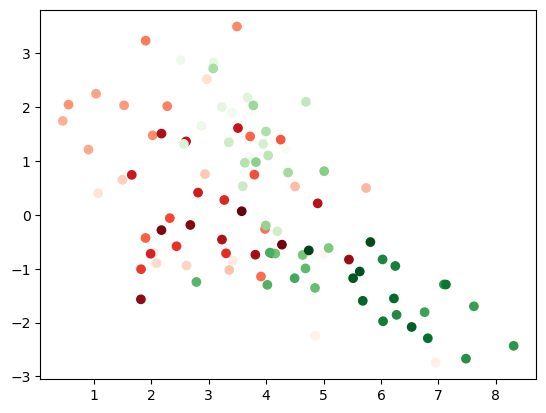

In [175]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

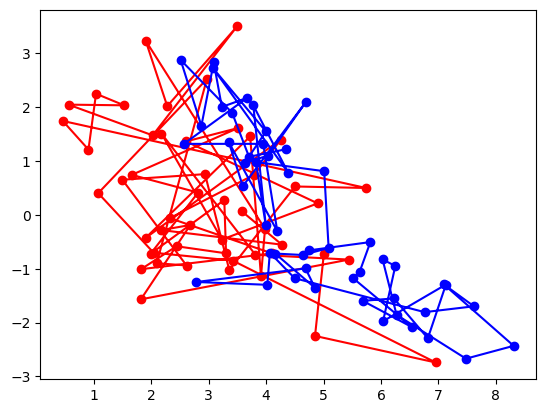

In [176]:
plt.plot(averaged_omission_pc[0], averaged_omission_pc[1], '-o', c="red")
plt.plot(averaged_rewarded_pc[0], averaged_rewarded_pc[1], '-o', c="blue")

plt.show()

In [177]:
all_categories = sorted(pc_product["rewarded_and_when"].unique())

In [178]:
all_categories

['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [179]:
all_colors = ["pink", "lightblue", "red", "cyan", "darkred", "darkcyan"]


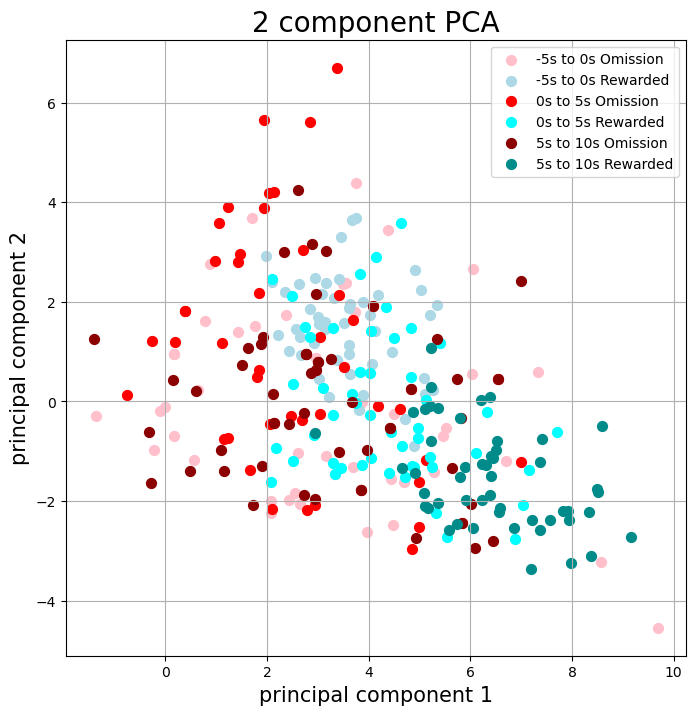

In [180]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

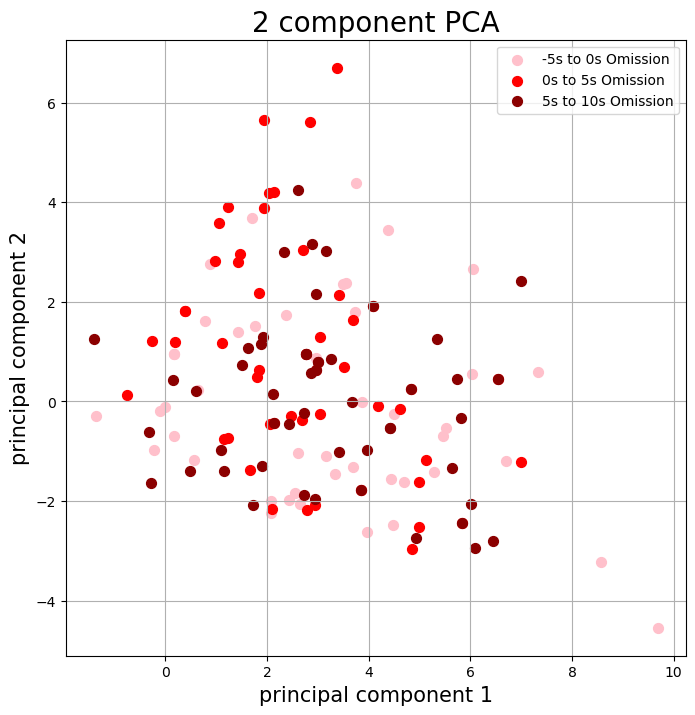

In [181]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

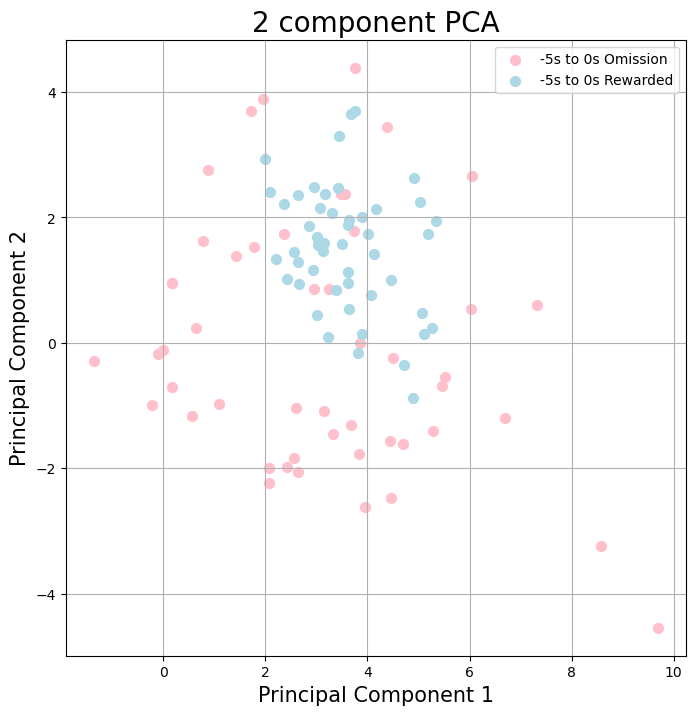

In [182]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

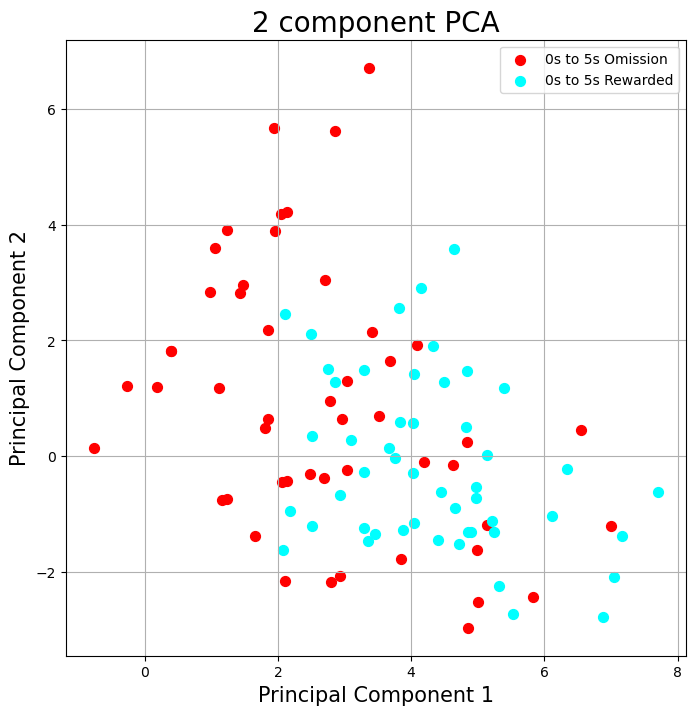

In [183]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

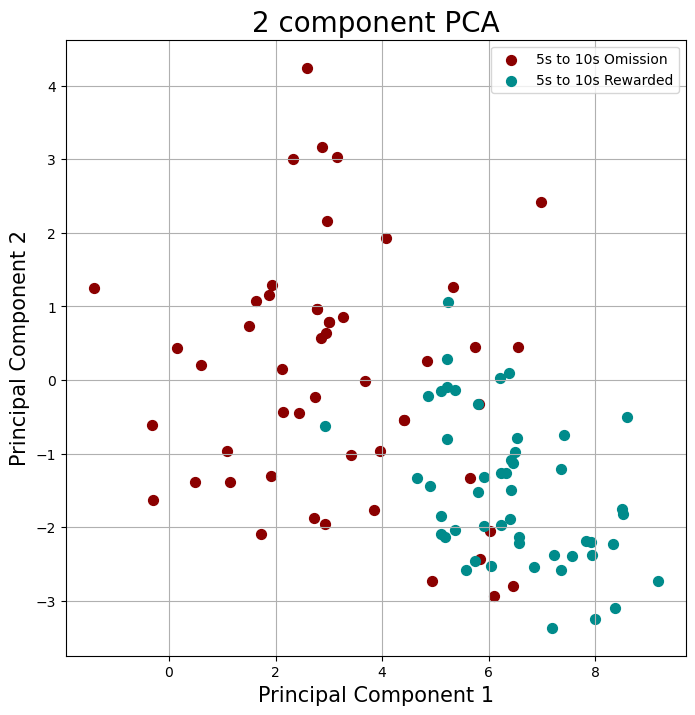

In [184]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['rewarded_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [185]:
firing_rate_and_pca_df = pd.concat([transposed_averaged_firing_rate_df.reset_index(), principal_df], axis=1)

In [186]:
firing_rate_and_pca_df

,"(index, )","(1, Omission)","(1, Rewarded)","(2, Omission)","(2, Rewarded)","(3, Omission)","(3, Rewarded)","(4, Omission)","(4, Rewarded)","(5, Omission)",...,"(147, Omission)","(147, Rewarded)","(148, Omission)","(148, Rewarded)","(149, Omission)","(149, Rewarded)","(150, Omission)","(150, Rewarded)",principal component 1,principal component 2
0,20,1.000000,0.9,1.333333,0.818182,1.333333,1.0,1.000000,1.000000,1.000000,...,1.000000,1.636364,0.666667,1.363636,1.333333,0.909091,0.5,1.454545,23.039293,-10.611915
1,64,0.333333,0.5,0.000000,0.545455,0.333333,0.4,0.333333,0.666667,0.666667,...,0.333333,0.181818,0.333333,0.272727,0.333333,0.727273,0.0,0.181818,-6.283194,-2.430065
2,54,0.000000,0.9,1.000000,0.818182,0.333333,1.3,0.000000,1.000000,0.000000,...,0.333333,0.636364,0.333333,0.363636,0.666667,0.454545,0.5,0.909091,8.553862,16.864909
3,16,0.000000,0.0,0.000000,0.090909,0.000000,0.0,0.333333,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.181818,0.000000,0.000000,0.0,0.090909,-15.308097,-2.803840
4,52,0.000000,0.1,0.333333,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,...,0.333333,0.272727,0.333333,0.090909,0.000000,0.272727,0.0,0.090909,-10.858046,-3.663357
5,24,1.333333,0.2,0.666667,0.818182,0.333333,0.5,0.000000,0.666667,1.333333,...,0.333333,0.272727,0.333333,0.454545,0.666667,0.363636,1.0,0.636364,0.856183,2.644267


In [187]:
firing_rate_and_pca_df

,"(index, )","(1, Omission)","(1, Rewarded)","(2, Omission)","(2, Rewarded)","(3, Omission)","(3, Rewarded)","(4, Omission)","(4, Rewarded)","(5, Omission)",...,"(147, Omission)","(147, Rewarded)","(148, Omission)","(148, Rewarded)","(149, Omission)","(149, Rewarded)","(150, Omission)","(150, Rewarded)",principal component 1,principal component 2
0,20,1.000000,0.9,1.333333,0.818182,1.333333,1.0,1.000000,1.000000,1.000000,...,1.000000,1.636364,0.666667,1.363636,1.333333,0.909091,0.5,1.454545,23.039293,-10.611915
1,64,0.333333,0.5,0.000000,0.545455,0.333333,0.4,0.333333,0.666667,0.666667,...,0.333333,0.181818,0.333333,0.272727,0.333333,0.727273,0.0,0.181818,-6.283194,-2.430065
2,54,0.000000,0.9,1.000000,0.818182,0.333333,1.3,0.000000,1.000000,0.000000,...,0.333333,0.636364,0.333333,0.363636,0.666667,0.454545,0.5,0.909091,8.553862,16.864909
3,16,0.000000,0.0,0.000000,0.090909,0.000000,0.0,0.333333,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.181818,0.000000,0.000000,0.0,0.090909,-15.308097,-2.803840
4,52,0.000000,0.1,0.333333,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,...,0.333333,0.272727,0.333333,0.090909,0.000000,0.272727,0.0,0.090909,-10.858046,-3.663357
5,24,1.333333,0.2,0.666667,0.818182,0.333333,0.5,0.000000,0.666667,1.333333,...,0.333333,0.272727,0.333333,0.454545,0.666667,0.363636,1.0,0.636364,0.856183,2.644267


In [188]:
principal_df.shape

(6, 2)

In [189]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

KeyError: 'bin'

In [ ]:
firing_rate_and_pca_df["rewarded_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["rewarded_and_when"].unique())

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# PCA with Time Bin Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principal_df.head()

In [ ]:
principal_df.shape

In [ ]:
principal_df.shape

In [ ]:
firing_rate_and_pca_df = pd.concat([resetted_averaged_firing_rate_df, principal_df], axis=1)

In [ ]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
firing_rate_and_pca_df["rewarded_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["rewarded_and_when"].unique())

In [ ]:
omission_categories = [name for name in sorted(firing_rate_and_pca_df["rewarded_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(firing_rate_and_pca_df["rewarded_and_when"].unique()) if "Rewarded" in name]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['rewarded_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
raise ValueError()

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [ ]:
DIN_state_array

In [ ]:
DIN_time_stamp = DIN_state_array[5][0]

In [ ]:
DIN_time_stamp

In [ ]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

- Array of the time stamp of all the frames

In [ ]:
[1431775 + num * 2000 for num in range(-50, 50)]

In [ ]:
len(within_interval_unit_times)

In [ ]:
range(1431775, 

In [ ]:
[1431775 + num * 2000 for num in range(50)]

In [ ]:
[(1431775 - (num + 1) * 2000, 1431775 - num * 2000) for num in range(50)][::-1]

In [ ]:
(4003716 - 3772337) / 20000

In [ ]:
(5204112 - 4003716) / 20000 

In [ ]:
(5404109 - 5204112) / 20000

In [ ]:
(6804107 - 5404109) / 20000

In [ ]:
3772337/20000/3600*60

In [ ]:
pos_timestamp_array

- Getting the first video time stamp that is greater than the voltage time stamp

In [ ]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [ ]:
current_video_frame

## Getting the specific frame

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

- Original frame number(before light turns on)

In [ ]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [ ]:
current_video_seconds = corrected_video_frame / fps

In [ ]:
current_video_seconds

In [ ]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [ ]:
voltage_timestamp_array[:5]

In [ ]:
voltage_timestamp_array.shape

In [ ]:
voltage_value_array[:5]

In [ ]:
voltage_value_array.shape

- Adding the voltage timestamps

In [ ]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [ ]:
ephys_dataframe.head()

- Adding the voltage value

In [ ]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [ ]:
ephys_dataframe.head()

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [ ]:
video_time_stamp_dict["data"][:5]

In [ ]:
video_time_stamp_dict["data"][-5:]

In [ ]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [ ]:
video_dataframe.head()

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [ ]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [ ]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [ ]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [ ]:
video_dataframe

## Combining the ephys and video dataframe into one

In [ ]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [ ]:
ephy_and_video_dataframe

In [ ]:
ephy_and_video_dataframe.columns

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [ ]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [ ]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [ ]:
ephy_and_video_dataframe.tail()

## Adding the DIN info

In [ ]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [ ]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [ ]:
DIN_dataframe

In [ ]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.dropna(subset=["time"])

In [ ]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.tail()

In [ ]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [ ]:
trial_1_df.head()

- Original frame number(before light turns on)

In [ ]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)